# Задача 4. Ансамбли

- [x] Найти данные размера хотя бы 10000, на которых можно решить задачу классификации или регрессии.
- [x] Выполнить разведочный анализ (**EDA**). При необходимости выполнить полезные преобразования данных.
- [x] Самостоятельно реализуйте алгоритмы **Bagging** и **AdaBoost**, которые позволят обучить ансамбли каких-то простых моделей, например деревьев принятия решений.
- [x] Обучите ансамбли для каких-то простых моделей, используя свои две реализации, а также реализации из **sklearn** (**Bagging**, **Random Forest**, **AdaBoost**, **Gradient Tree Boosting**, **Histogram-Based Gradient Boosting**).
- [x] При обучении использовать **подбор гиперпараметров**, **кросс-валидацию**.
- [x] Сравнить качество моделей: замерить скорость обучения, вычислить различные метрики качества, построить матрицы ошибок.
- [x] (**+2 балла**) Также добавить в сравнение модели из библиотек **XGBoost**, **LightGBM** и **CatBoost**.
- [x] (**+3 балла**) Для подбора гиперпараметров использовать фреймворк **Optuna**.

In [96]:

import pathlib

import pandas
import seaborn as sns
from matplotlib import pyplot as plt

pandas.set_option("display.max_columns", None)

madrid_houses_dataset_path = pathlib.Path().cwd().resolve() / "ml-course" / "solutions" / "datasets" / "madrid_houses_clean.csv"

# Dataset

Используем чистый набор данных Мадрида рынка недвижимости -- [Madrid houses-clean](https://www.kaggle.com/datasets/makofe/housesclean)

Предполагается решать задачу регрессии: определить цену домов по демографическим данным и географическому положению относительно Мадрида.

Нецелевые аттрибуты:

- sq_mt_built — размер дома в кв.м
- n_rooms — количество комнат
- n_bathrooms — количество ванных комнат
- n_floors — количество этажей
- sq_mt_allotment — общая площадь участка
- floor — высота
- is_renewal_needed — требуется обновление / ремонт
- has_lift — наличие лифта
- is_exterior — внешняя часть здания
- energy_certificate — чем больше число, тем эффективнее
- has_parking — наличие парковки
- neighborhood — округ / графство
- district — район
- house_type — тип дома (квартира, дом, кабинет, дуплекс, верхний этаж)

Целевой аттрибут:

- buy_price — цена дома

In [97]:
madrid_houses_dataset = pandas.read_csv(madrid_houses_dataset_path, sep=',', header=0, index_col=0,
                                        encoding="utf-8").drop(columns=["id"])

madrid_houses_dataset.describe()

,sq_mt_built,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,buy_price,energy_certificate,neighborhood,district,house_type
count,21739.000000,21739.000000,21739.000000,21739.000000,21739.000000,21739.000000,2.173900e+04,21739.000000,21739.000000,21739.000000,21739.000000
mean,153.814950,3.006026,2.091265,1.233727,57.811951,1.833249,6.535729e+05,1.139289,62.802337,9.747412,1.407746
std,164.718815,1.510356,1.407185,0.709524,397.720529,3.039869,7.819661e+05,1.902396,38.343388,5.587888,1.016465
min,13.000000,0.000000,1.000000,1.000000,0.000000,-5.000000,3.600000e+04,0.000000,1.000000,1.000000,1.000000
25%,70.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.980000e+05,0.000000,30.000000,5.000000,1.000000
50%,100.000000,3.000000,2.000000,1.000000,0.000000,2.000000,3.750000e+05,0.000000,59.000000,9.000000,1.000000
75%,165.000000,4.000000,2.000000,1.000000,0.000000,4.000000,7.625000e+05,3.000000,94.000000,14.000000,1.000000
max,2400.000000,24.000000,16.000000,7.000000,21000.000000,10.000000,8.800000e+06,7.000000,135.000000,21.000000,5.000000


Заменим значения boolean на float для более удобной работы с ними.

In [98]:
madrid_houses_dataset = madrid_houses_dataset.astype('float64')
madrid_houses_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21739 entries, 0 to 21741
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sq_mt_built         21739 non-null  float64
 1   n_rooms             21739 non-null  float64
 2   n_bathrooms         21739 non-null  float64
 3   n_floors            21739 non-null  float64
 4   sq_mt_allotment     21739 non-null  float64
 5   floor               21739 non-null  float64
 6   buy_price           21739 non-null  float64
 7   is_renewal_needed   21739 non-null  float64
 8   has_lift            21739 non-null  float64
 9   is_exterior         21739 non-null  float64
 10  energy_certificate  21739 non-null  float64
 11  has_parking         21739 non-null  float64
 12  neighborhood        21739 non-null  float64
 13  district            21739 non-null  float64
 14  house_type          21739 non-null  float64
dtypes: float64(15)
memory usage: 2.7 MB


Корректировка пропущенных значений не требуется за их отсутствием.

Заметим, что в данные добавлялись с сохранением географического порядка, в частности подряд просматривается совпадение районов и округов, поэтому при кросс-валидации перемешаем данные.

# EDA

## Распределение данных

Рассмотрим распределение аттрибутов.

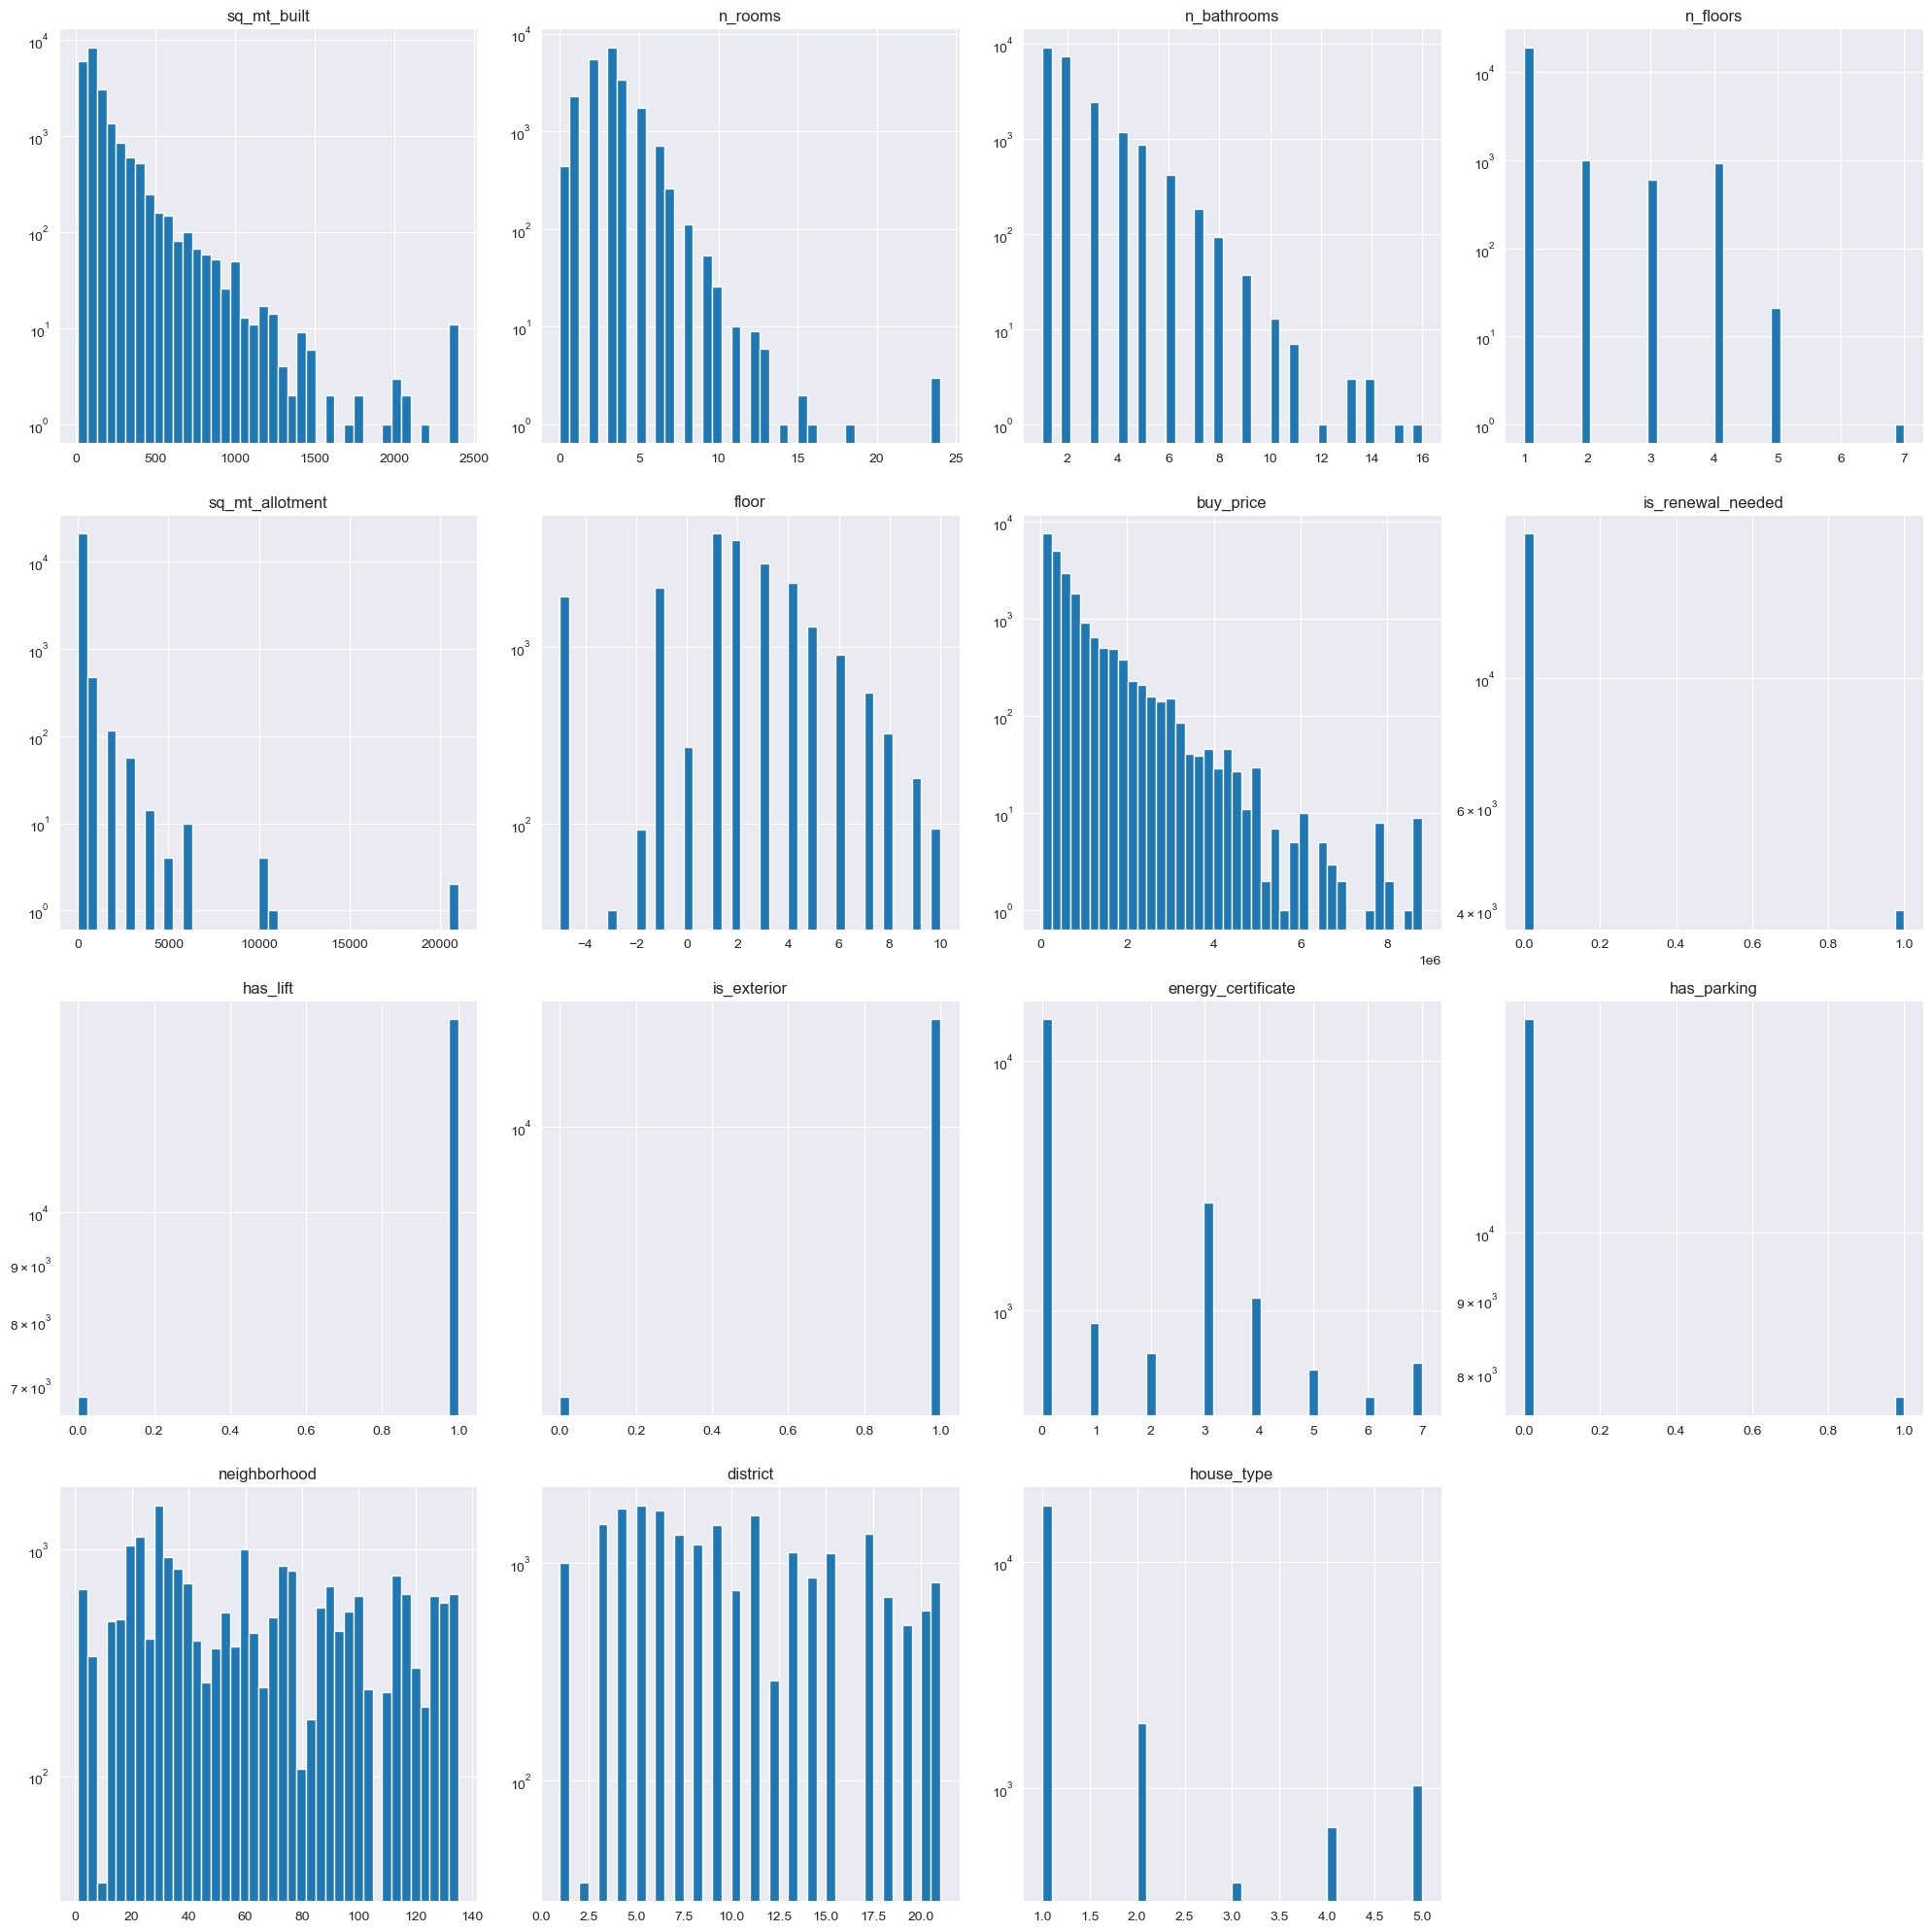

In [99]:
madrid_houses_dataset.hist(bins=40, log=True, figsize=(20, 20))
plt.tight_layout()

Значения аттрибутов цены и размера дома имеют довольно плавное распределение. Значения общей площади участка имеют резкие перепады после 1000 кв.м.

## Корреляция аттрибутов

Попробуем проследить зависимость цены, квадратной площади и типа дома.

Заметим, что **больша́я часть данных имеет цену менее 4 млн., а также площадь менее 1000 кв.м**

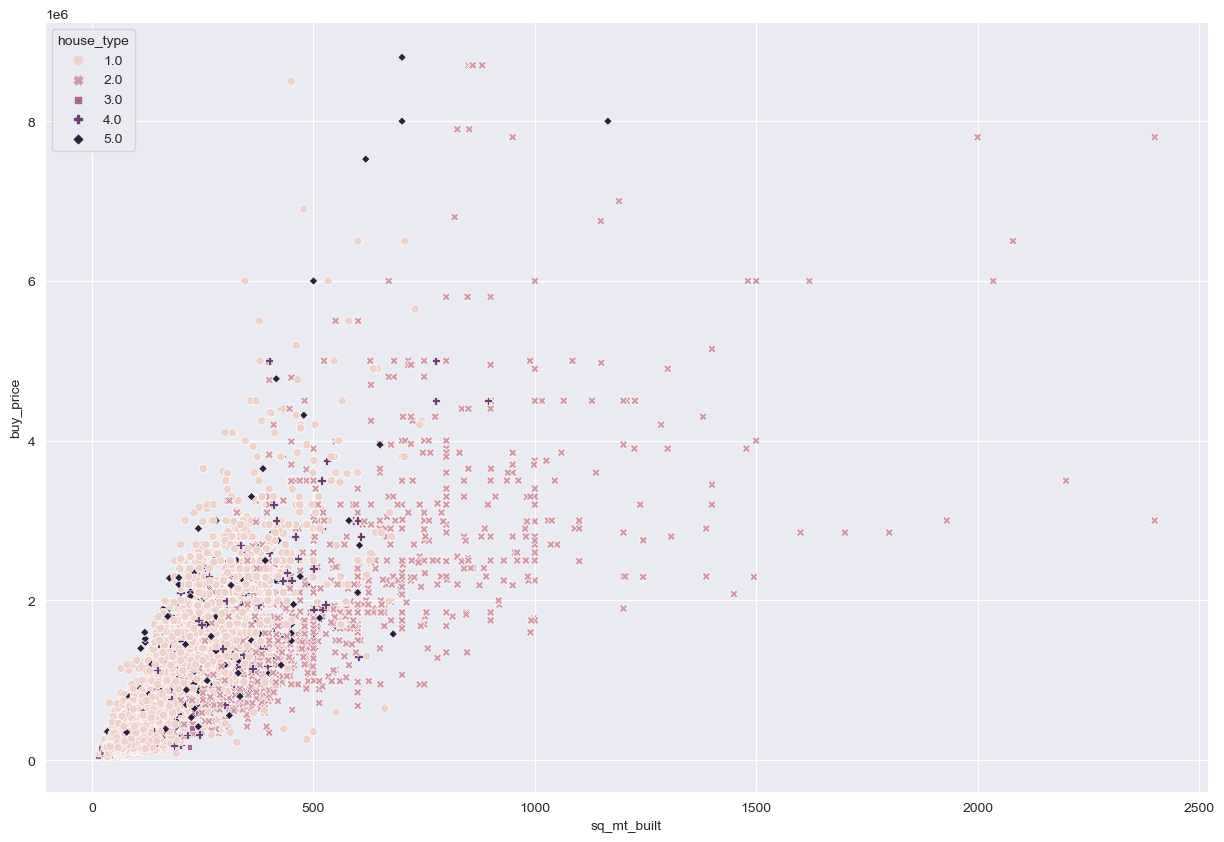

In [100]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x='sq_mt_built', y='buy_price', hue='house_type', style='house_type', data=madrid_houses_dataset)
plt.show()

Рассмотрим распределение цен и убедимся в сделанном выводе.

count    2.173900e+04
mean     6.535729e+05
std      7.819661e+05
min      3.600000e+04
25%      1.980000e+05
50%      3.750000e+05
75%      7.625000e+05
max      8.800000e+06
Name: buy_price, dtype: float64


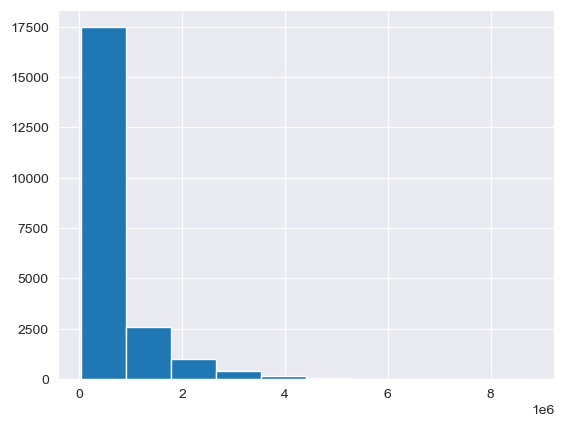

In [101]:
print(madrid_houses_dataset.buy_price.describe())
madrid_houses_dataset.buy_price.hist(bins=10)
plt.show()

Уберем все дома ценой более 4 млн. и более 1000 кв.м. Это небольшая группа, но очень разрозненная. Около 281 домов, 1,3%.

Таким образом уменьшим значения ошибок.

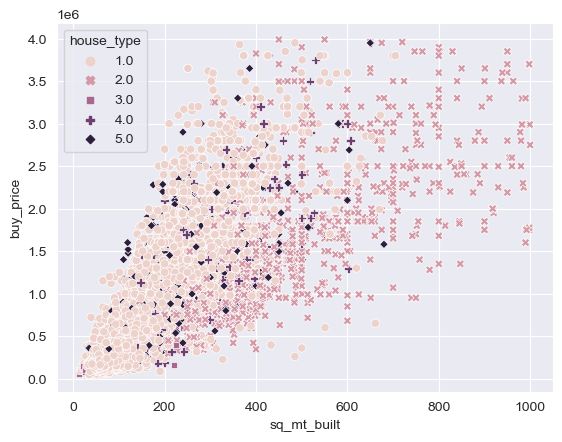

In [102]:
madrid_houses_dataset = madrid_houses_dataset[madrid_houses_dataset.buy_price < 4000000]
madrid_houses_dataset = madrid_houses_dataset[madrid_houses_dataset.sq_mt_built < 1000]
madrid_houses_dataset.describe()

sns.scatterplot(x='sq_mt_built', y='buy_price', hue='house_type', style='house_type', data=madrid_houses_dataset)
plt.show()


Заметим, что средняя цена дома составляет около 600 тыс.

count    2.145800e+04
mean     6.035687e+05
std      6.294225e+05
min      3.600000e+04
25%      1.961600e+05
50%      3.690000e+05
75%      7.450000e+05
max      3.990000e+06
Name: buy_price, dtype: float64


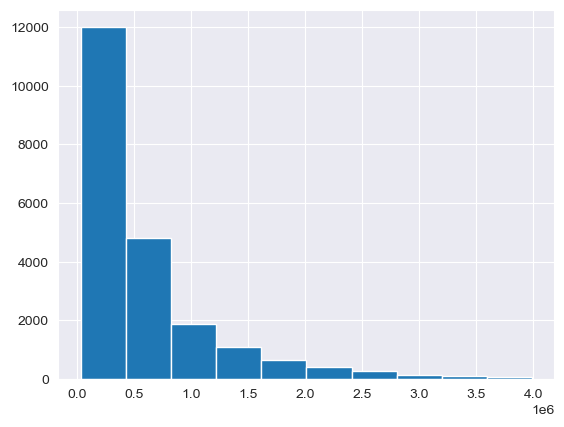

In [103]:
print(madrid_houses_dataset.buy_price.describe())
madrid_houses_dataset.buy_price.hist(bins=10)
plt.show()

Смотрим зависимости аттрибутов не касающихся расположения домов.

Как ни странно, **с увеличением площади дома растет и его цена**.

Проследим ожидаемую положительную корреляцию между площадью, числом комнат, числом ванных комнат, количеством этажей, общей площадью дома и ценой.

<AxesSubplot:>

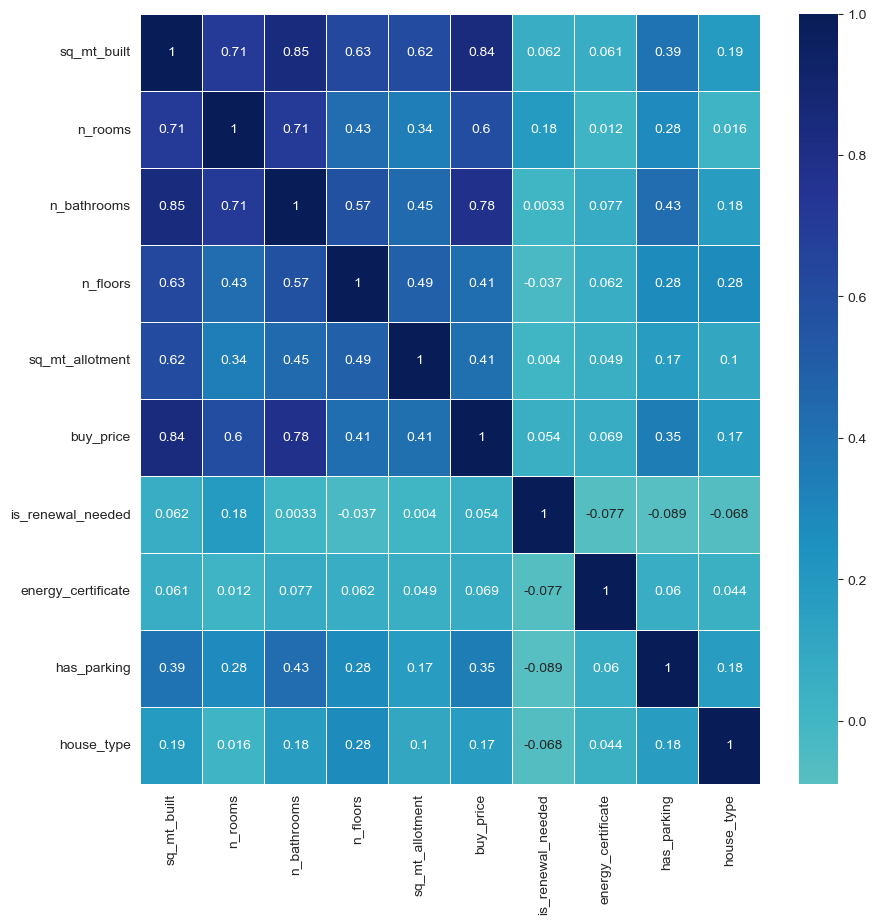

In [104]:
sns.heatmap(madrid_houses_dataset.drop(columns=["floor", "has_lift", "is_exterior", "neighborhood", "district"]).corr(),
            center=0, annot=True, cmap="YlGnBu", linewidths=.5, ax=plt.subplots(figsize=(10, 10))[1])

Используя данные о местоположении дома в Мадриде, сделаем выводы о средней стоимости домов в том или ином районе.

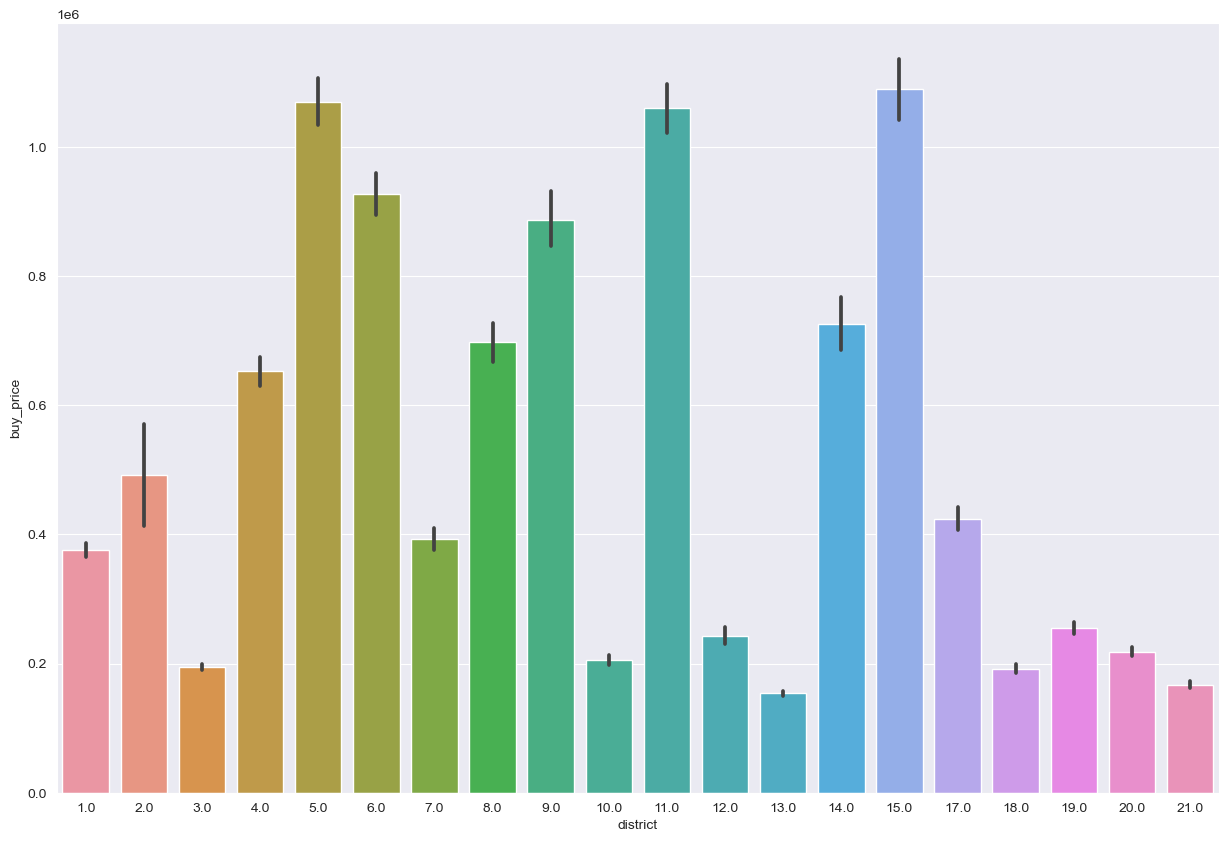

In [105]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x='district', y='buy_price', data=madrid_houses_dataset)
plt.show()

Помимо вышесказанного рассмотрим более детальное распределение цен по округу (в данном случае district включает в себя несколько neighborhood). Заметим, **что несмотря на принадлежность домов к одному району, их цена может зависеть от аттрибута neighborhood**.

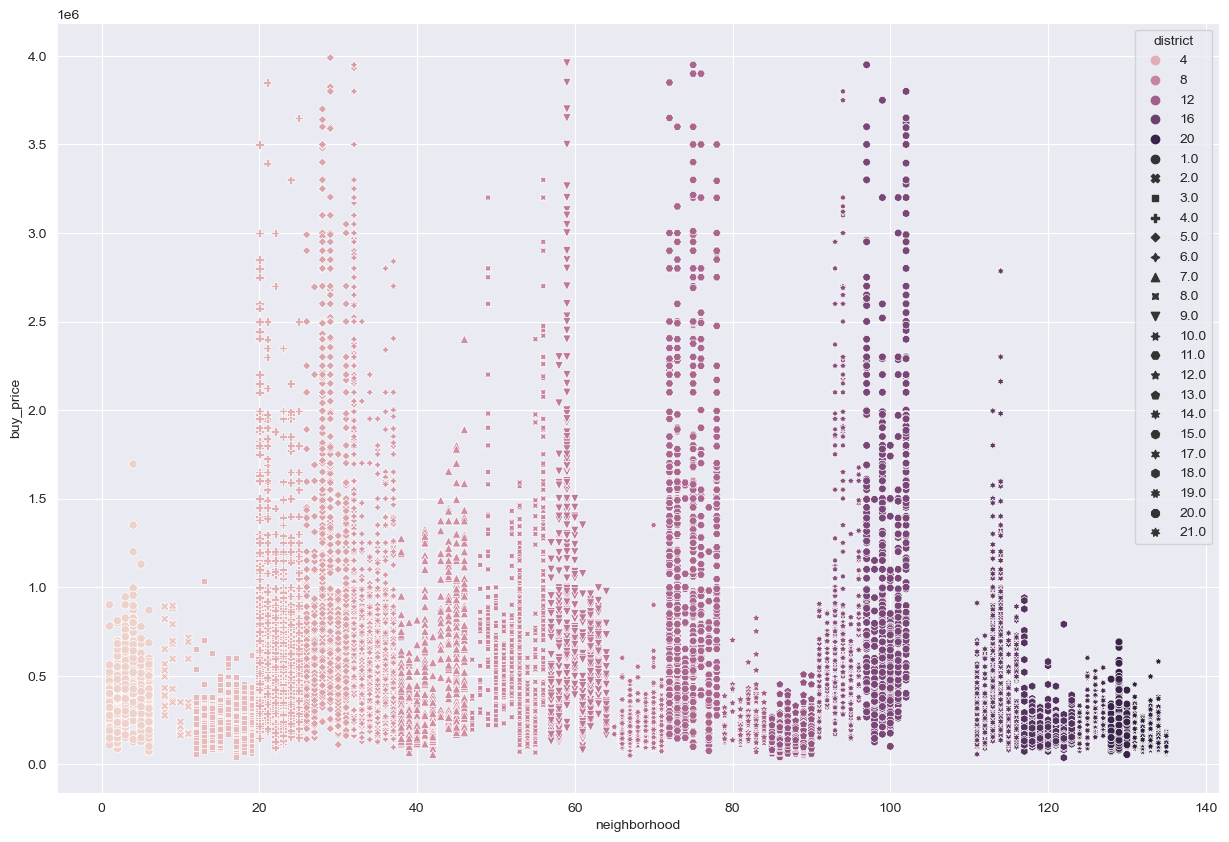

In [106]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.scatterplot(x='neighborhood', y='buy_price', hue="district", style="district", data=madrid_houses_dataset)
plt.show()

Итак, можно ожидать, что размер дома, количество комнат, этажей, а также принадлежность к району и округу, будут ощутимо влиять на целевой аттрибут -- цену дома.

# Собственные реализации

## Bagging

In [107]:
import numpy as np
import numpy.typing as npt
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils.validation import check_X_y, check_scalar, check_random_state, check_is_fitted, check_array
from sklearn.utils.estimator_checks import check_estimator

In [108]:
class SimpleBaggingRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, estimator=None, n_estimators=10, *, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        predictions = [estimator.predict(X) for estimator in self.estimators_]
        aggregated = np.mean(predictions, axis=0)
        return aggregated

    def fit(self, x, y) -> "SimpleBaggingRegressor":
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        x, y = check_X_y(x, y)
        self._set_estimator()
        self.estimators_ = []
        for i in range(self.n_estimators):
            estimator = clone(self.estimator_)
            self._set_random_states(estimator)
            X_sample, y_sample = self._bootstrap_resample(x, y)
            estimator.fit(X_sample, y_sample)
            self.estimators_.append(estimator)
        self.n_features_in_ = x.shape[1]

        return self

    def _bootstrap_resample(self, X, y):
        bootstrap_indices = self.random_state_.choice(len(y), size=len(y))
        return X[bootstrap_indices], y[bootstrap_indices]

    def _set_random_states(self, estimator):
        random_states = {}
        for param_name in estimator.get_params(deep=True):
            if param_name == "random_state" or param_name.endswith("__random_state"):
                random_states[param_name] = self.random_state_.tomaxint()
        estimator.set_params(**random_states)

    def _set_estimator(self):
        self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeRegressor()


check_estimator(SimpleBaggingRegressor(), generate_only=True)

<generator object check_estimator.<locals>.checks_generator at 0x000001E8870B1350>

## AdaBoost

In [109]:
class SimpleAdaBoostRegressor(BaseEstimator, RegressorMixin):

    def __init__(self, estimator=None, n_estimators=50, *, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.random_state = random_state

    def fit(self, X: npt.ArrayLike, y: npt.ArrayLike) -> "SimpleAdaBoostRegressor":
        self.n_estimators = check_scalar(self.n_estimators, "n_estimators", int, min_val=1)
        self.random_state_ = check_random_state(self.random_state)
        X, y = check_X_y(X, y, y_numeric=True)
        self._set_estimator()
        self.estimators_ = []
        self.estimator_weights_ = []
        sample_weight = np.full(len(y), fill_value=(1 / len(y)))
        for _ in range(self.n_estimators):
            estimator = clone(self.estimator_)
            predicted = estimator.fit(X, y, sample_weight=sample_weight).predict(X)
            errors = np.abs(predicted - y)
            max_error = np.max(errors)
            errors /= max_error if max_error != 0 else 1
            avg_error = np.sum(errors * sample_weight)
            if avg_error == 0:
                self.estimators_.append(estimator)
                self.estimator_weights_.append(1.0)
                break
            elif avg_error >= 0.5:
                if len(self.estimators_) == 0:
                    self.estimators_.append(estimator)
                    self.estimator_weights_.append(1.0)
                break
            beta = avg_error / (1 - avg_error)
            sample_weight *= np.power(beta, 1 - errors)
            sample_weight /= np.sum(sample_weight)
            self.estimators_.append(estimator)
            self.estimator_weights_.append(np.log(1 / beta))
        self.estimator_weights_ = np.array(self.estimator_weights_)
        self.n_features_in_ = X.shape[1]

        return self

    def predict(self, X: npt.ArrayLike):
        check_is_fitted(self)
        X = check_array(X)
        predictions = np.array([estimator.predict(X) for estimator in self.estimators_]).T
        sorted_prediction_ids = np.argsort(predictions, axis=1)
        sorted_weights_cumsum = np.cumsum(self.estimator_weights_[sorted_prediction_ids], axis=1)
        is_median_or_above = sorted_weights_cumsum >= (sorted_weights_cumsum[0][-1] / 2)
        median_ids = np.argmax(is_median_or_above, axis=1)
        median_ids = sorted_prediction_ids[np.arange(len(X)), median_ids]
        aggregated = predictions[np.arange(len(X)), median_ids]

        return aggregated

    def _set_estimator(self):
        self.estimator_ = self.estimator if self.estimator is not None else DecisionTreeRegressor(max_depth=3)


check_estimator(SimpleAdaBoostRegressor(), generate_only=True)

<generator object check_estimator.<locals>.checks_generator at 0x000001E887027900>

## Optuna

In [124]:
from pandas import DataFrame
import pathlib
import warnings
import optuna
from sklearn.model_selection import KFold, cross_validate

warnings.filterwarnings("ignore", category=optuna.exceptions.ExperimentalWarning)

RESULTS_PATH = pathlib.Path().cwd() / "cv_results.csv"

def train_and_store(estimator, param_distributions: dict):
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    optuna.logging.set_verbosity(optuna.logging.INFO)
    study = optuna.create_study(
        sampler=optuna.samplers.BruteForceSampler(),
        direction="maximize",
    )
    search_model = optuna.integration.OptunaSearchCV(
        estimator,
        param_distributions,
        scoring="r2",
        n_jobs=2,
        n_trials=None,
        random_state=82,
        study=study,
    )
    cv_results = cross_validate(
        search_model,
        dataset.data,
        dataset.target,
        cv=KFold(shuffle=True, random_state=23),
        scoring=["r2", "neg_mean_absolute_error"],
        n_jobs=3,
        return_estimator=True,
    )
    for fold_i, estimator_in_fold in enumerate(cv_results["estimator"], start=1):
        print(f"Best params #{fold_i}:", estimator_in_fold.best_params_)
    cv_results = pandas.DataFrame(cv_results).rename(
        columns={"estimator": "Estimator", "fit_time": "Fit time(s)", "score_time": "Score time(s)", "test_r2": "R2/test"}
    )
    cv_results["Estimator"] = estimator.__class__.__name__.removesuffix("Estimator")
    cv_results["MAE/test"] = -cv_results["test_neg_mean_absolute_error"]
    cv_results = cv_results.drop(columns=["test_neg_mean_absolute_error"])
    cv_results.to_csv(RESULTS_PATH, mode="a", header=not RESULTS_PATH.exists())

In [128]:
%%time

train_and_store(
    SimpleBaggingRegressor(random_state=0),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 20, 40]),
    },
)

[I 2023-03-26 20:51:59,278] A new study created in memory with name: no-name-5c1a338e-d57f-4212-b8eb-1950a43ebca0


Best params #1: {'n_estimators': 40}
Best params #2: {'n_estimators': 40}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 40}
Best params #5: {'n_estimators': 40}
Wall time: 1min 1s


In [129]:
%%time
from sklearn.ensemble import BaggingRegressor

train_and_store(
    BaggingRegressor(random_state=1, n_jobs=2),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([10, 20, 40]),
    }
)

[I 2023-03-26 20:53:56,878] A new study created in memory with name: no-name-cc872f7f-7746-44b0-806f-12d4b7ab6ea3


Best params #1: {'n_estimators': 40}
Best params #2: {'n_estimators': 40}
Best params #3: {'n_estimators': 40}
Best params #4: {'n_estimators': 40}
Best params #5: {'n_estimators': 40}
Wall time: 43.5 s


In [130]:
%%time
from sklearn.ensemble import RandomForestRegressor

train_and_store(
    RandomForestRegressor(random_state=2, n_jobs=2),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([20, 100, 200]),
        "max_features": optuna.distributions.CategoricalDistribution([2, "sqrt", None]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 100, None]),
    },
)

[I 2023-03-26 20:54:45,925] A new study created in memory with name: no-name-f2a6785f-3d36-4b3c-8fef-12dcb73ed9e9


Best params #1: {'n_estimators': 200, 'max_features': None, 'max_leaf_nodes': None}
Best params #2: {'n_estimators': 200, 'max_features': None, 'max_leaf_nodes': None}
Best params #3: {'n_estimators': 200, 'max_features': None, 'max_leaf_nodes': None}
Best params #4: {'n_estimators': 100, 'max_features': None, 'max_leaf_nodes': None}
Best params #5: {'n_estimators': 200, 'max_features': None, 'max_leaf_nodes': None}
Wall time: 7min 3s


In [131]:
%%time

train_and_store(
    SimpleAdaBoostRegressor(random_state=3),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 50, 100]),
    },
)

[I 2023-03-26 21:02:09,641] A new study created in memory with name: no-name-99c9b5d9-cd2b-4b31-a241-c5cd301db6f0


Best params #1: {'n_estimators': 5}
Best params #2: {'n_estimators': 5}
Best params #3: {'n_estimators': 5}
Best params #4: {'n_estimators': 5}
Best params #5: {'n_estimators': 5}
Wall time: 12.1 s


In [132]:
%%time
from sklearn.ensemble import AdaBoostRegressor

train_and_store(
    AdaBoostRegressor(random_state=4),
    param_distributions={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([5, 20, 100]),
    },
)

[I 2023-03-26 21:02:44,360] A new study created in memory with name: no-name-d4326085-b1a0-4cf1-a85e-b287c27f13f6


Best params #1: {'learning_rate': 0.03, 'n_estimators': 100}
Best params #2: {'learning_rate': 0.03, 'n_estimators': 100}
Best params #3: {'learning_rate': 0.03, 'n_estimators': 100}
Best params #4: {'learning_rate': 0.03, 'n_estimators': 100}
Best params #5: {'learning_rate': 0.03, 'n_estimators': 100}
Wall time: 1min 5s


In [133]:
%%time
from sklearn.ensemble import GradientBoostingRegressor

train_and_store(
    GradientBoostingRegressor(random_state=5),
    param_distributions={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([20, 100, 200]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([10, 1000, None]),
    },
)

[I 2023-03-26 21:03:57,709] A new study created in memory with name: no-name-efcfff30-a4fa-4f29-b7a1-130f4852aeb6


Best params #1: {'learning_rate': 0.1, 'n_estimators': 200, 'max_leaf_nodes': 1000}
Best params #2: {'learning_rate': 0.1, 'n_estimators': 200, 'max_leaf_nodes': None}
Best params #3: {'learning_rate': 0.1, 'n_estimators': 200, 'max_leaf_nodes': None}
Best params #4: {'learning_rate': 0.1, 'n_estimators': 200, 'max_leaf_nodes': None}
Best params #5: {'learning_rate': 0.1, 'n_estimators': 200, 'max_leaf_nodes': None}
Wall time: 6min 40s


In [135]:
%%time
from sklearn.ensemble import HistGradientBoostingRegressor

train_and_store(
    HistGradientBoostingRegressor(random_state=6),
    param_distributions={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.1, 0.2, 0.3]),
        "max_iter": optuna.distributions.CategoricalDistribution([100, 200, 500]),
        "max_leaf_nodes": optuna.distributions.CategoricalDistribution([5, 15, 45]),
        "early_stopping": optuna.distributions.CategoricalDistribution([False, True]),
    },
)

[I 2023-03-26 21:11:28,636] A new study created in memory with name: no-name-ca9d1f78-6e66-4a81-b418-8ffdfbd577b9


Best params #1: {'learning_rate': 0.1, 'max_iter': 200, 'max_leaf_nodes': 15, 'early_stopping': True}
Best params #2: {'learning_rate': 0.1, 'max_iter': 200, 'max_leaf_nodes': 15, 'early_stopping': True}
Best params #3: {'learning_rate': 0.1, 'max_iter': 500, 'max_leaf_nodes': 5, 'early_stopping': False}
Best params #4: {'learning_rate': 0.1, 'max_iter': 500, 'max_leaf_nodes': 15, 'early_stopping': True}
Best params #5: {'learning_rate': 0.2, 'max_iter': 500, 'max_leaf_nodes': 5, 'early_stopping': False}
Wall time: 8min 41s


In [137]:
%%time
from xgboost import XGBRegressor

train_and_store(
    XGBRegressor(random_state=7, n_jobs=2),
    param_distributions={
        "tree_method": optuna.distributions.CategoricalDistribution(["exact", "approx", "hist"]),
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([100, 200, 400]),
        "max_leaves": optuna.distributions.CategoricalDistribution([1, 3, 15, 31]),
    },
)

[I 2023-03-26 21:25:22,179] A new study created in memory with name: no-name-984ff39f-43a2-4a0d-8356-7fc4ad5a3e2d


Best params #1: {'tree_method': 'hist', 'learning_rate': 0.1, 'n_estimators': 200, 'max_leaves': 31}
Best params #2: {'tree_method': 'hist', 'learning_rate': 0.1, 'n_estimators': 400, 'max_leaves': 31}
Best params #3: {'tree_method': 'hist', 'learning_rate': 0.1, 'n_estimators': 200, 'max_leaves': 15}
Best params #4: {'tree_method': 'hist', 'learning_rate': 0.1, 'n_estimators': 200, 'max_leaves': 15}
Best params #5: {'tree_method': 'hist', 'learning_rate': 0.1, 'n_estimators': 200, 'max_leaves': 15}
Wall time: 12min 28s


In [138]:
%%time
from lightgbm import LGBMRegressor

train_and_store(
    LGBMRegressor(random_state=8, n_jobs=2),
    param_distributions={
        "learning_rate": optuna.distributions.CategoricalDistribution([0.03, 0.1, 0.3]),
        "n_estimators": optuna.distributions.CategoricalDistribution([25, 50, 100]),
        "num_leaves": optuna.distributions.CategoricalDistribution([5, 13, 40]),
    },
)

[I 2023-03-26 21:39:29,613] A new study created in memory with name: no-name-9876af25-56de-41e2-9c77-f52d8524d6a4


Best params #1: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 13}
Best params #2: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 13}
Best params #3: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 13}
Best params #4: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 40}
Best params #5: {'learning_rate': 0.3, 'n_estimators': 50, 'num_leaves': 13}
Wall time: 17.3 s


In [139]:
%%time
from catboost import CatBoostRegressor

train_and_store(
    CatBoostRegressor(random_state=9, thread_count=2),
    param_distributions={
        "n_estimators": optuna.distributions.CategoricalDistribution([250, 375, 500]),
    },
)

[I 2023-03-26 21:42:45,947] A new study created in memory with name: no-name-b2389118-9264-4630-be6c-bd4d23c5e7fd


Best params #1: {'n_estimators': 500}
Best params #2: {'n_estimators': 500}
Best params #3: {'n_estimators': 375}
Best params #4: {'n_estimators': 500}
Best params #5: {'n_estimators': 375}
Wall time: 49.1 s


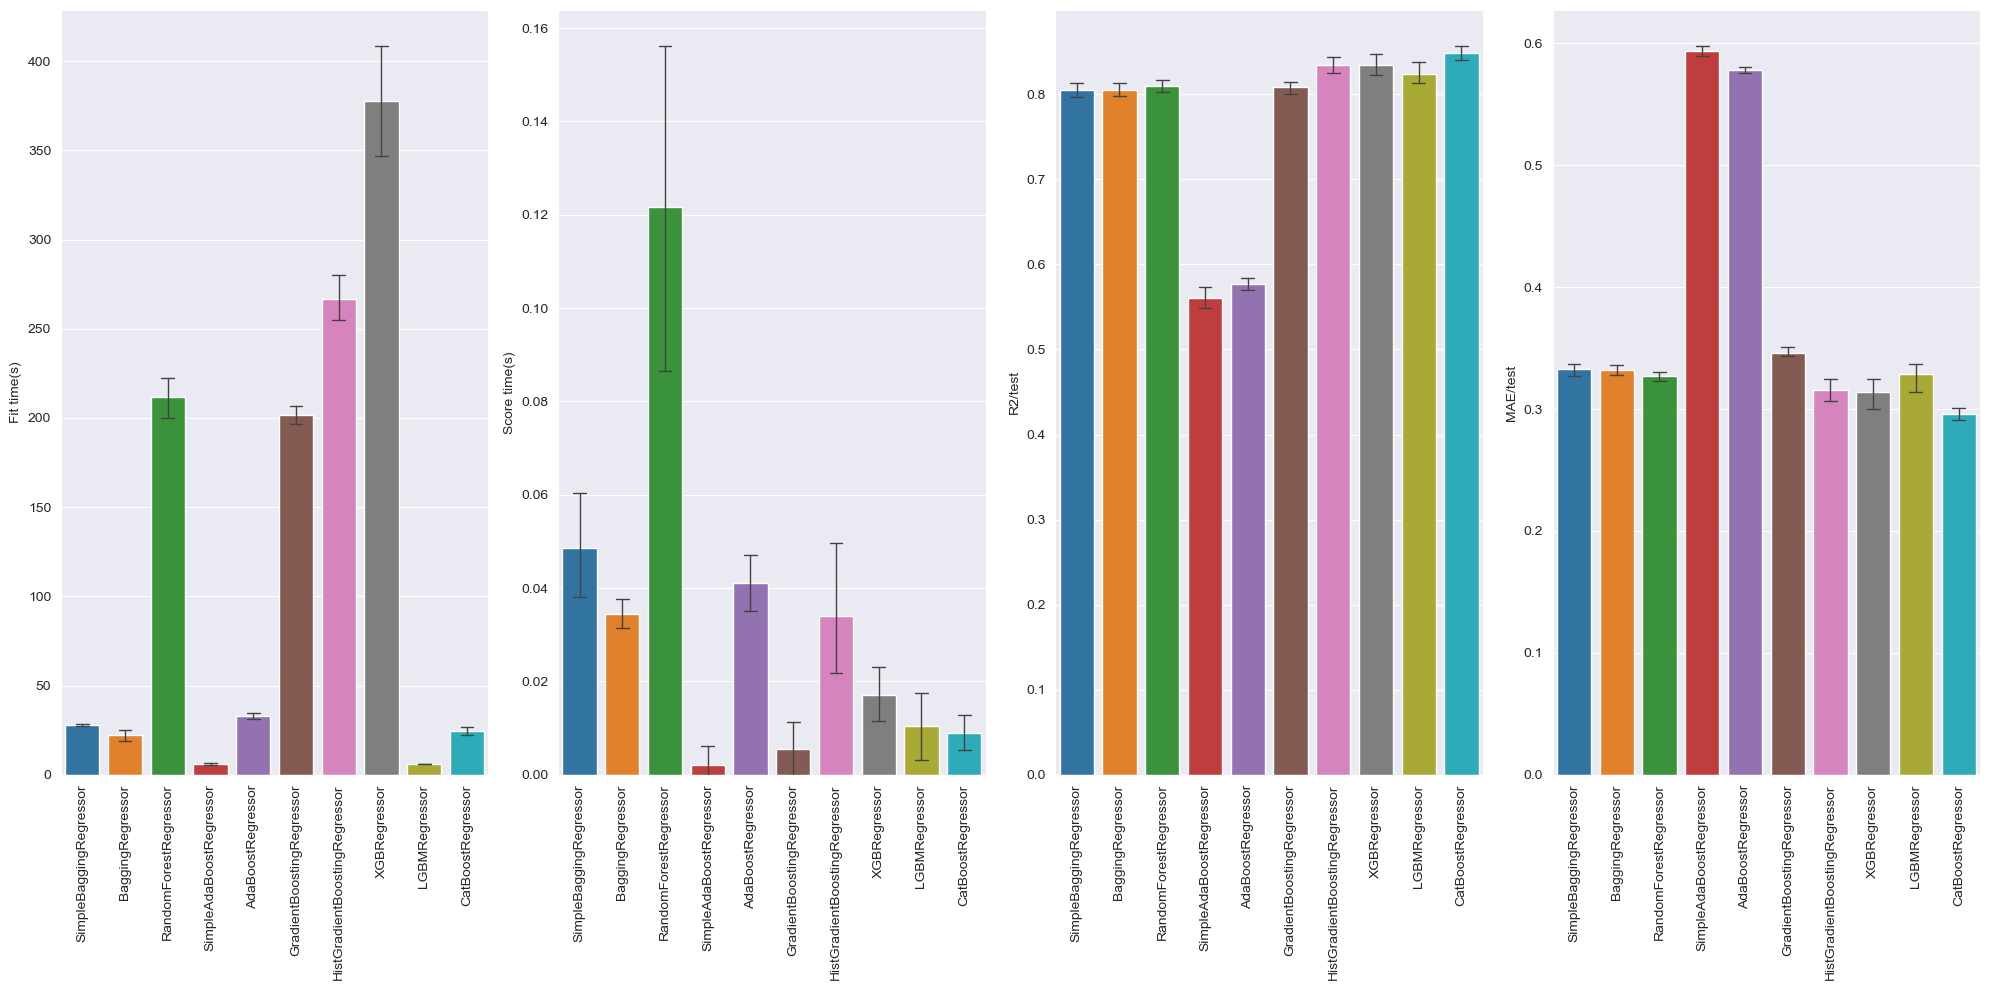

In [143]:
cv_results_amalgamated = pandas.read_csv(RESULTS_PATH)

fig, axs = plt.subplots(ncols=4, figsize=(20, 10))

for y, ax in zip(["Fit time(s)", "Score time(s)", "R2/test", "MAE/test"], axs.flatten()):
    sns.barplot(data=cv_results_amalgamated[["Estimator", y]], x="Estimator", y=y, errwidth=1, capsize=0.3, ax=ax)
    ax.tick_params(axis="x", rotation=90)
    ax.set_xlabel(None)

fig.tight_layout()

plt.show()

## Выводы

Явным лидером по представленным метрикам стал алгоритм CatBoost, средняя ошибка составляет менее 30.000, что составляет 5% от средней цены дома. Что касается самописных алгоритмов, они проигрывают по времени, но показывают себя не сильно хуже по качественны метрикам.